In [39]:
from openpiv import tools, process, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio

In [2]:
import openpiv.tools
import openpiv.process 
import openpiv.scaling 
import openpiv.validation 
import openpiv.filters
import glob

# Batch Processing

### check if pictures are in order, if not, sort them

In [4]:
files = glob.glob("/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/*.jpg")
files


['/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_118.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_115.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_117.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_116.jpg']

In [5]:
def Frame_sort(x):
    return(x[-7:-4])

files_S =sorted(files, key = Frame_sort)
files_S

['/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_115.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_116.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_117.jpg',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/f10_CLIP/DJI_0003_20180726_1440-Vpt6postTypeA-Copy1.MOV_118.jpg']

### Extract frame 0 and make a list of frames (will use this to save files based off of frame 0)

In [6]:
frame0= files_S[0]
frame0 = int(frame0[-7:-4])
frame0

115

In [7]:
FrameN = []
for i in range(len(files)):
    F1 = str(frame0 +i)
    FrameN.append(F1)
    i = i+1
FrameN

['115', '116', '117', '118']

In [8]:
savedir = '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/'

In [21]:
i=0
for i in range(len(files_S)-1):
    print(savedir + 'Vel_Field_' + FrameN[i]+ '_' + FrameN[i+1] ) 

/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_115_116
/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_116_117
/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_117_118


In [144]:
savedir = '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/'
file
files_S
print(savedir  + "_%03d.csv" % i )

/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/_000.csv


## Batch Process

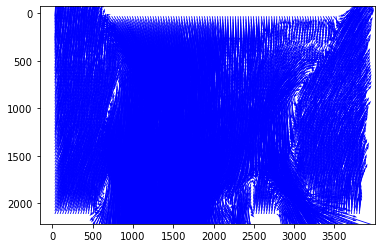

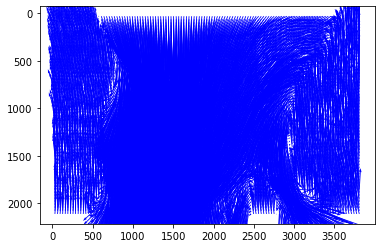

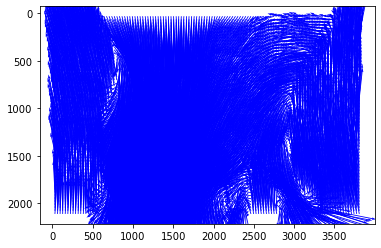

In [23]:
i=0
for i in range(len(files_S)-1):
    frame_a  = tools.imread(files_S[i])
    frame_b  = tools.imread(files_S[i+1])
    frame_a = (frame_a).astype(np.int32)
    frame_b = (frame_b).astype(np.int32)

    u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
        window_size=64, overlap=32, dt=1, search_area_size=128, sig2noise_method='peak2peak' )
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
    u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.2 )
    u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
    u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
    tools.save(x, y, u, v, mask, savedir + 'Vel_Field_' + FrameN[i]+ '_' + FrameN[i+1] + '.csv')
    tools.display_vector_field(savedir + 'Vel_Field_' + FrameN[i]+ '_' + FrameN[i+1] + '.csv', scale=400, width=0.001)
    i =i+1
    

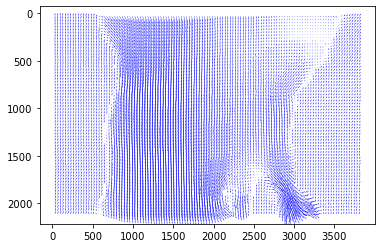

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f81b6ed7040>)

In [30]:
tools.display_vector_field(savedir + 'Vel_Field_115_116.csv' , scale=400, width=0.001)

## Subtract out motion from drone
assuming this is a relatively 'stationary' drone flight

In [46]:
V_Fields = glob.glob(savedir + "*.csv")
V_Fields

['/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_116_117.csv',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_115_116.csv',
 '/Users/Jasper/Volc_Research/OpenPIV/F10_Clip/F10_Savedir/Vel_Field_117_118.csv']

### Display Vector Field 1 
to select a 'still' region that will be appopriate to subtract

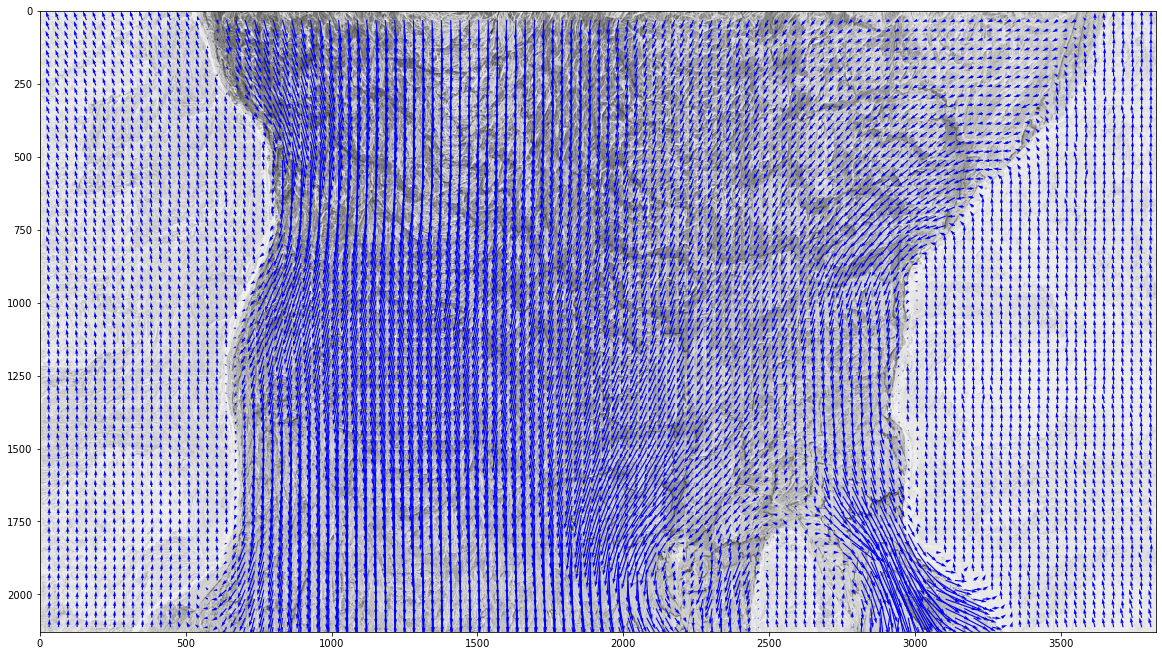

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f81b6097130>)

In [51]:
fig,ax = plt.subplots(figsize=(20,20))
tools.display_vector_field(V_Fields[0], scale=400, width=0.001,ax=ax,on_img=True,image_name=files_S[0])

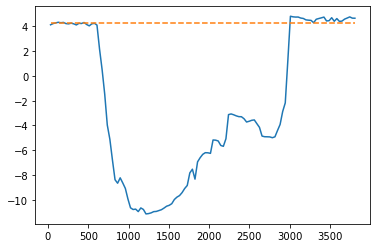

In [58]:
#visual representation of what is being done
plt.plot(x[0,:],v[35,:].T)
plt.plot(x[0,:],np.ones_like(x[0,:])*4.3,'--')
plt.show()

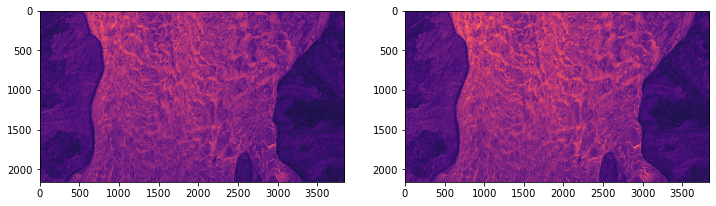

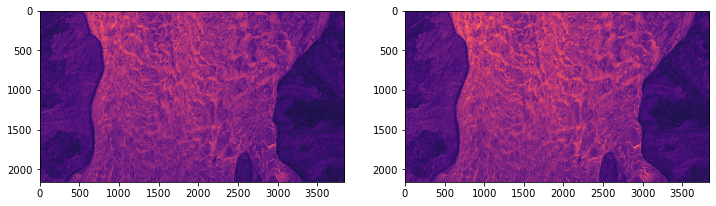

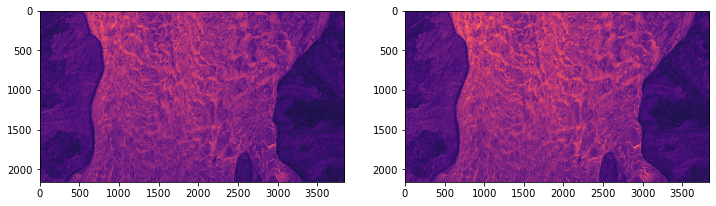

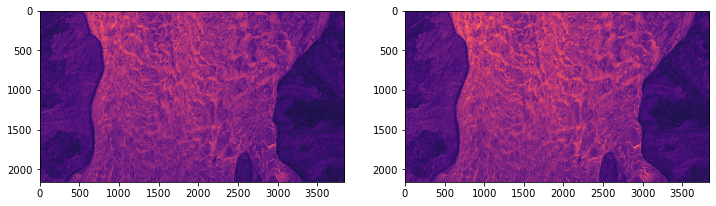

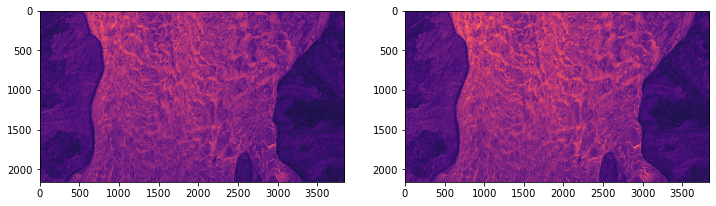

In [35]:
i=0
while(i<=len(files_S)):
    fig,ax = plt.subplots(1,2,figsize=(12,10))
    ax[0].imshow(frame_a,cmap=plt.cm.magma)
    ax[1].imshow(frame_b,cmap=plt.cm.magma)
    i = i+1

